LIBRERÍAS NECESARIAS PARA LA PRÁCTICA Y ENLACE CON DRIVE:



In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import efficientnet_b0
from torchvision.models import vgg16
import ast
from tqdm import tqdm
import os
import tensorflow as tf
import torchvision
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import io
import cv2
import zipfile

In [106]:
# Importamos los métodos necesarios para el módulo
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos imágenes: Descomprimimos, creamos rutas

In [104]:
#Ruta al archivo ZIP
zip_path = '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main.zip'

#Carpeta donde se descomprimiran los archivos
data_main_path = '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/'

#Creo la carpeta de extraccion
os.makedirs(data_main_path, exist_ok = True)

#Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(data_main_path)

#Archivos descomprimidos
extracted_files = os.listdir(data_main_path)

# 1. Preparación y Análisis de Datos

ANÁLISIS EXPLORATORIO DATASET

In [107]:
# *** CARGA DE DATOS ***
# A través del fichero facilitado (poi_dataset.csv) obtenemos los datos, sobre
# los que luego realizaremos el train y el test.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Luego, leemos los datos del archivo CSV
data_path = '../poi_dataset.csv'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/poi_dataset.csv')

Usando dispositivo: cpu


In [108]:
print(f"Tamaño del dataset: {df.shape[0]} filas y {df.shape[1]} columnas")

Tamaño del dataset: 1569 filas y 14 columnas


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1569 non-null   object 
 1   name              1569 non-null   object 
 2   shortDescription  1569 non-null   object 
 3   categories        1569 non-null   object 
 4   tier              1569 non-null   int64  
 5   locationLon       1569 non-null   float64
 6   locationLat       1569 non-null   float64
 7   tags              1569 non-null   object 
 8   xps               1569 non-null   int64  
 9   Visits            1569 non-null   int64  
 10  Likes             1569 non-null   int64  
 11  Dislikes          1569 non-null   int64  
 12  Bookmarks         1569 non-null   int64  
 13  main_image_path   1569 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 171.7+ KB


In [110]:
df.describe()

,tier,locationLon,locationLat,xps,Visits,Likes,Dislikes,Bookmarks
count,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000
mean,1.541109,-1.132337,39.900141,750.382409,10011.943276,3623.908222,2526.305927,973.261950
std,0.637677,22.733401,9.662134,228.319854,5.456808,4817.879374,2225.543360,1453.333948
min,1.000000,-121.951049,-62.940930,0.000000,10001.000000,100.000000,52.000000,50.000000
25%,1.000000,-3.725292,40.411754,600.000000,10008.000000,464.000000,937.000000,116.000000
50%,1.000000,-3.699140,40.421738,700.000000,10011.000000,1434.000000,2718.000000,306.000000
75%,2.000000,-3.673348,40.472458,1000.000000,10015.000000,6840.000000,3399.000000,1309.000000
max,4.000000,158.333118,65.706572,1000.000000,10038.000000,26425.000000,10999.000000,8157.000000


In [111]:
df.head()

,id,name,shortDescription,categories,tier,locationLon,locationLat,tags,xps,Visits,Likes,Dislikes,Bookmarks,main_image_path
0,4b36a3ed-3b28-4bc7-b975-1d48b586db03,Galería Fran Reus,La Galería Fran Reus es un espacio dedicado a ...,"['Escultura', 'Pintura']",1,2.642262,39.572694,[],500,10009,422,3582,78,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...
1,e32b3603-a94f-49df-8b31-92445a86377c,Convento de San Plácido,"El Convento de San Plácido en Madrid, fundado ...","['Patrimonio', 'Historia']",1,-3.704467,40.423037,[],500,10010,7743,96,2786,data_main/e32b3603-a94f-49df-8b31-92445a86377c...
2,0123a69b-13ac-4b65-a5d5-71a95560cff5,Instituto Geológico y Minero de España,"El Instituto Geológico y Minero de España, sit...","['Ciencia', 'Patrimonio']",2,-3.699694,40.442045,[],250,10015,3154,874,595,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...
3,390d7d9e-e972-451c-b5e4-f494af15e788,Margarita Gil Roësset,"Margarita Gil Roësset, escultora y poetisa esp...",['Cultura'],1,-3.691228,40.427256,[],500,10011,8559,79,2358,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...
4,023fc1bf-a1cd-4b9f-af78-48792ab1a294,Museo del Traje. Centro de Investigación del P...,"El Museo del Traje de Madrid, fundado en 2004,...","['Patrimonio', 'Cultura']",1,-3.727822,40.439665,[],500,10020,915,2896,143,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...


In [112]:
df.isnull().sum()

,0
id,0
name,0
shortDescription,0
categories,0
tier,0
locationLon,0
locationLat,0
tags,0
xps,0
Visits,0


In [113]:
# Para poder visualizar la información, mostramos todas las columnas (sabiendo cuantas hay)

print(f"COLUMNAS DEL DATASET:\n{df.columns}")

print("\nDistribución de las categorías en 'categories': \n", df['categories'].value_counts())
print("\nDistribución de las categorías en 'tier': \n",df['tier'].value_counts())
print("\nDistribución de las categorías en 'tags': \n",df['tags'].value_counts())

COLUMNAS DEL DATASET:
Index(['id', 'name', 'shortDescription', 'categories', 'tier', 'locationLon',
       'locationLat', 'tags', 'xps', 'Visits', 'Likes', 'Dislikes',
       'Bookmarks', 'main_image_path'],
      dtype='object')

Distribución de las categorías en 'categories': 
 categories
['Patrimonio', 'Historia', 'Arquitectura']           100
['Patrimonio', 'Arquitectura', 'Historia']            84
['Historia', 'Cultura', 'Escultura']                  76
['Cultura', 'Patrimonio', 'Historia', 'Misterio']     69
['Cultura', 'Escultura', 'Historia']                  66
                                                    ... 
['Cine', 'Historia', 'Cultura']                        1
['Arquitectura', 'Ocio', 'Escultura']                  1
['Cultura', 'Arquitectura', 'Ocio']                    1
['Arquitectura', 'Ciencia', 'Escultura']               1
['Historia', 'Gastronomía']                            1
Name: count, Length: 224, dtype: int64

Distribución de las categorías en 'tier':

VARIABLES A CODIFICAR
Info de las 14 columnas:
* ID: identificación.
* SHORTDESCRIPTION: descripción objetiva.
* CATEGORIES: Tiene diferentes opciones, por lo que sería buena opción.
* TIER: clasificación del nivel de disponibilidad.
* LOCATION_LON-LAT: ubicación posicional.
* TAGS: palabras.
* XPS:.
* VISITS: visitas a cada ubicación.
* LIKES/DISLIKES/BOOKMARKS: los utilizaremos para hacer el engagement.
* MAIN_IMAGE_PATH: son las imágenes, que luego trataremos.




MÉTRICAS DE ENGAGEMENT (visitas, likes, dislikes, bookmarks)

In [114]:
# FÓRMULA PARA ENGAGEMENT: Likes + Dislikes >= 800% de las Visits
df['engagement_level'] = ((df['Likes'] + df['Dislikes']) >= 0.8 * df['Visits']).astype(int)


# Resultados iniciales
print("\nVALORES PARA ENGAGEMENT:")
print(df[['Likes', 'Dislikes', 'Visits', 'engagement_level']].head())


#Conteo: bajo (0) o alto (1)
engagement_distribution = df['engagement_level'].value_counts()
print("\nVALORES DE ENGAGEMENT (0: Bajo, 1: Alto):")
print(engagement_distribution)


# Cálculo del porcentaje
engagement_percentage = engagement_distribution / df.shape[0] * 100
print("\nPORCENTAJES DE ENGAGEMENT:")
print(engagement_percentage)


VALORES PARA ENGAGEMENT:
   Likes  Dislikes  Visits  engagement_level
0    422      3582   10009                 0
1   7743        96   10010                 0
2   3154       874   10015                 0
3   8559        79   10011                 1
4    915      2896   10020                 0

VALORES DE ENGAGEMENT (0: Bajo, 1: Alto):
engagement_level
0    1068
1     501
Name: count, dtype: int64

PORCENTAJES DE ENGAGEMENT:
engagement_level
0    68.068834
1    31.931166
Name: count, dtype: float64


TRATAMIENTO DE IMÁGENES

Lo primero que haremos será la carga de las imágenes y su procesamiento, para después mostrar características (tamaño) y calcular las imágenes empleadas para el Train y el Test.

Normalizamos y redimensionamos; eliminamos columnas innecesarias.

In [115]:
#Normalizo las coordenadas geograficas
scaler = MinMaxScaler()
df[['locationLon', 'locationLat']] = scaler.fit_transform(df[['locationLon', 'locationLat']])
print(df[['locationLon', 'locationLat']].head())

   locationLon  locationLat
0     0.444525     0.796857
1     0.421881     0.803467
2     0.421898     0.803614
3     0.421928     0.803499
4     0.421798     0.803596


In [116]:
image_paths = []

#recorrer las carpetas dentro de la carpeta data_main
for folder in os.listdir(data_main_path):
  folder_path = os.path.join(data_main_path, folder)

  #mirar que sea una carpeta
  if os.path.isdir(folder_path):
    #miro el archivo 'main.jpg' dentro de cada carpeta
    image_path = os.path.join(folder_path, 'main.jpg')

    #Miro si el archivo .jpg existe
    if os.path.exists(image_path):
      image_paths.append(image_path)

#Verifico algunas rutas de imagenes, para ver que sea correcto
print(image_paths[:5])

['/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/528ea5b5-2232-410a-8876-979d711551ff/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/52a6c6c5-3bbe-45db-bedf-72583bd76762/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/548c6d8d-bea0-460f-996a-bac08c5f939a/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/52eea70c-65fe-4281-9cbb-bf8959c828b5/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/52c137b8-ab26-402f-ac2d-5fc83bbab098/main.jpg']


In [117]:
print(f"Cantidad de imágenes en image_paths: {len(image_paths)}")
print("Contenido de image_paths:", image_paths)


Cantidad de imágenes en image_paths: 1492
Contenido de image_paths: ['/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/528ea5b5-2232-410a-8876-979d711551ff/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/52a6c6c5-3bbe-45db-bedf-72583bd76762/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/548c6d8d-bea0-460f-996a-bac08c5f939a/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/52eea70c-65fe-4281-9cbb-bf8959c828b5/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/52c137b8-ab26-402f-ac2d-5fc83bbab098/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/546587b8-6173-4c24-afab-94e4d138178b/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/549c79e3-0b17-4f3a-94bc-0b30ad14e580/main.jpg', '/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/data_main/54d0c12f-8a0b-446c-8ac6-d6e97f589544/main.j

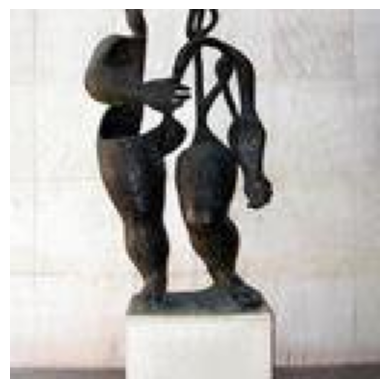

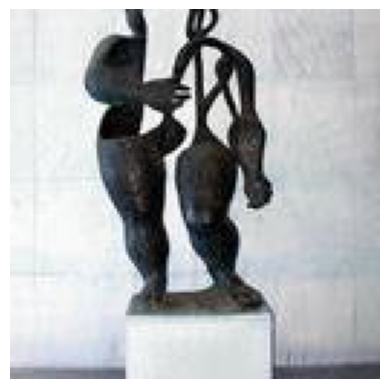

In [118]:
#Visualizo las imagenes originales
#Cargo imagen para ver como esta
example_image_path = image_paths[0] # Assuming image_paths is a list and you want the first element
example_image = cv2.imread(example_image_path)

#convierto de BGR a RGB
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

#mostrar la imagen
plt.imshow(example_image)
plt.axis('off')
plt.show()
#convierto de BGR a RGB
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

#mostrar la imagen
plt.imshow(example_image)
plt.axis('off')
plt.show()

In [119]:
#1. Procesado de imágenes

image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.ToTensor(),          # Convertir a tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalización a rango [-1, 1]
])

print(df.columns)

Index(['id', 'name', 'shortDescription', 'categories', 'tier', 'locationLon',
       'locationLat', 'tags', 'xps', 'Visits', 'Likes', 'Dislikes',
       'Bookmarks', 'main_image_path', 'engagement_level'],
      dtype='object')


In [120]:
# 2. Eliminación de columnas que no aportan valor

columns_to_drop = ['id', 'name', 'shortDescription']

df = df.drop(columns=columns_to_drop)

print("\nCOLUMNAS TRAS ELIMINACIÓN:")
print(df.columns)


COLUMNAS TRAS ELIMINACIÓN:
Index(['categories', 'tier', 'locationLon', 'locationLat', 'tags', 'xps',
       'Visits', 'Likes', 'Dislikes', 'Bookmarks', 'main_image_path',
       'engagement_level'],
      dtype='object')


In [ ]:
# 3. Preprocesado

df['categories_encoded'] = LabelEncoder().fit_transform(df['categories'])
df['tier_encoded'] = LabelEncoder().fit_transform(df['tier'])
df['tags_encoded'] = LabelEncoder().fit_transform(df['tags'])

# Normalizar las columnas numéricas
numeric_cols = ['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("\nVISUALIZACIÓN DEL PREPROCESADO:")
print(df.head())


VISUALIZACIÓN DEL PREPROCESADO:
                   categories  tier  locationLon  locationLat tags       xps  \
0    ['Escultura', 'Pintura']     1     0.166091    -0.033901   [] -1.096980   
1  ['Patrimonio', 'Historia']     1    -0.113179     0.054135   [] -1.096980   
2   ['Ciencia', 'Patrimonio']     2    -0.112969     0.056103   [] -2.192284   
3                 ['Cultura']     1    -0.112597     0.054572   [] -1.096980   
4   ['Patrimonio', 'Cultura']     1    -0.114207     0.055857   [] -1.096980   

     Visits     Likes  Dislikes  Bookmarks  \
0 -0.539549 -0.664801  0.474505  -0.616202   
1 -0.356233  0.855232 -1.092354   1.247694   
2  0.560346 -0.097565 -0.742665  -0.260355   
3 -0.172917  1.024655 -1.099995   0.953105   
4  1.476924 -0.562441  0.166167  -0.571463   

                                     main_image_path  engagement_level  \
0  data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...                 0   
1  data_main/e32b3603-a94f-49df-8b31-92445a86377c...         

DIVISIÓN EN TRAIN/VALIDATION/TEST

Train: 70%
Validation: 15%
Test: 15%

In [ ]:
train_df, temp_df = train_test_split( df, test_size=0.30, random_state=42,
    stratify=df['engagement_level']  # Mantener proporciones en engagement_level
)

val_df, test_df = train_test_split( temp_df, test_size=0.5,  # 50% de Temp -> 15% del total
    random_state=42,
    stratify=temp_df['engagement_level']
)

In [ ]:
print(f"Datos para el train: {train_df.shape[0]} filas")
print(f"Datos para validación: {val_df.shape[0]} filas")
print(f"Datos para test: {test_df.shape[0]} filas")


Datos para el train: 1098 filas
Datos para validación: 235 filas
Datos para test: 236 filas


Incluimos los valores del engagement

In [125]:
def check_class_distribution(data, subset_name):
    dist = data['engagement_level'].value_counts(normalize=True)
    print(f"\nDistribución de engagement_level en {subset_name}:")
    print(dist)

# Visualizar las distribuciones y valores del engagement:
check_class_distribution(train_df, "Train")
check_class_distribution(val_df, "Validation")
check_class_distribution(test_df, "Test")


Distribución de engagement_level en Train:
engagement_level
0    0.680328
1    0.319672
Name: proportion, dtype: float64

Distribución de engagement_level en Validation:
engagement_level
0    0.680851
1    0.319149
Name: proportion, dtype: float64

Distribución de engagement_level en Test:
engagement_level
0    0.682203
1    0.317797
Name: proportion, dtype: float64


Una vez que hemos trabajado con los datos y las imágenes, vamos a unificar todo en un único dataset, para poder trabajar mejor

In [128]:
class POIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

# Carga y preprocesado de la imagen desde la columna 'main_image_path'
        image_path = row['main_image_path']
        try:
            img = Image.open(image_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except FileNotFoundError:
            img = torch.zeros((3, 128, 128))

# Extraer metadatos
        metadata_cols = ['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks',
                         'categories_encoded', 'tier_encoded', 'tags_encoded']
        metadata = row[metadata_cols].values.astype(float)

# Engagement level como target
        target = row['engagement_level']

        return {
            'image': img,
            'metadata': torch.tensor(metadata, dtype=torch.float32),
            'target': torch.tensor(target, dtype=torch.float32)
                   }

Antes de generar de nuevo los datos para Train, Validation y Test, se calcula el tamaño del Bath:

In [130]:
batch_size = 32

In [131]:
# Creamos de nuevo los train, validation y test:
train_dataset = POIDataset(train_df, transform=image_transforms)
val_dataset = POIDataset(val_df, transform=image_transforms)
test_dataset = POIDataset(test_df, transform=image_transforms)

# Crear los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar un Batch
for batch in train_loader:
    print("\nBatch de entrenamiento:")
    print(f"Imágenes: {batch['image'].shape}")
    print(f"Metadatos: {batch['metadata'].shape}")
    print(f"Targets: {batch['target'].shape}")
    break


Batch de entrenamiento:
Imágenes: torch.Size([32, 3, 128, 128])
Metadatos: torch.Size([32, 10])
Targets: torch.Size([32])


# 2. ARQUITECTURA DEL MODELO

RED CONVOLUCIONAL

In [132]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()
    def forward(self, x):
        return self.resnet(x)

In [133]:
# ===========
# Prueba de red convolucional:
# ===========

image_encoder = ImageEncoder() #codificador de imágenes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

image_encoder = image_encoder.to(device)

example_images = torch.randn(20, 3, 128, 128).to(device)  # Batch de 20 imágenes, tamaño 128x128

image_features = image_encoder(example_images) #Imágenes a través de codificador creado

print(f"Tamaño de imágenes: {image_features.shape}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Usando dispositivo: cpu
Tamaño de imágenes: torch.Size([20, 512])


CAPAS FULLY-CONNECTED PARA METADATA

In [134]:
class MetadataEncoder(nn.Module):
    def __init__(self, input_dim, output_dim=32):
        super(MetadataEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),   # Primera capa
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),          # Segunda capa
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_dim)    # Tercera capa.
        )

    def forward(self, x):
        return self.encoder(x)

In [135]:
# ===========
# Prueba con Capas Fully-Connected:
# ===========

metadata_input_dim = len(['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks',
                          'categories_encoded', 'tier_encoded', 'tags_encoded'])
example_metadata = torch.randn(20, metadata_input_dim)  # Batch de 20 muestras

metadata_encoder = MetadataEncoder(input_dim=metadata_input_dim) # Instancia para codificador

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Mover el modelo a GPU (si está disponible)

metadata_encoder = metadata_encoder.to(device)
example_metadata = example_metadata.to(device)

metadata_features = metadata_encoder(example_metadata)  # Metadatos a través del codificador

print(f"TAMAÑO DE METADATOS: {metadata_features.shape}")

TAMAÑO DE METADATOS: torch.Size([20, 32])


EXPERIMENTACIÓN CON ARQUITECTURAS PRE-ENTRENADAS (EFFICIENTNET)

In [141]:
class EfficientNetEncoder(nn.Module):
    def __init__(self):

        super(EfficientNetEncoder, self).__init__()

        # Cargamosel EfficientNet-B0 que hemos preentrenado antes
        self.efficientnet = efficientnet_b0(pretrained=True)

        # Eliminación de la última capa de clasificación (fc)
        self.efficientnet.classifier = nn.Identity()

    def forward(self, x):
        return self.efficientnet(x)

In [143]:
# Crear una instancia del codificador de imágenes con EfficientNet-B0
efficientnet_encoder = EfficientNetEncoder()

efficientnet_encoder = efficientnet_encoder.to(device)

# Crear un batch simulado de imágenes (batch_size=20)(tamaño de imagen: 128x128)
example_images = torch.randn(20, 3, 128, 128).to(device)

# Vuelco a EfficientNet
image_features = efficientnet_encoder(example_images)

print(f"Tamaño de las características de las imágenes (EfficientNet): {image_features.shape}")

Tamaño de las características de las imágenes (EfficientNet): torch.Size([20, 1280])


JUSTIFICACIÓN DE DECISIONES ARQUITECTÓCNICAS

Analizando los resultados arrojados, vemos que los datos obtenidos el vector con más tamaño sale con EfficientNet (20,1520) mientras que en CNN se obtiene un valor de (20,520)

No entro a valorar las arquitecturas pre-entrenadas, por falta de conocimiento en ellas.

Intentamos realizar un model híbrido, con Flluy-connected y EfficientNet.

In [144]:
class HybridModel(nn.Module):
    def __init__(self, metadata_input_dim, image_feature_dim=1280, fusion_hidden_dim=128, num_classes=1):

        super(HybridModel, self).__init__()

        # Codificador de imágenes (EfficientNet-B0 preentrenada)
        self.image_encoder = EfficientNetEncoder()

        # Codificador de metadatos (MetadataEncoder mejorado)
        self.metadata_encoder = MetadataEncoder(input_dim=metadata_input_dim, output_dim=32)

        # Capas Fully-Connected para la fusión
        self.fc_fusion = nn.Sequential(
            nn.Linear(image_feature_dim + 32, fusion_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden_dim, num_classes),
            nn.Sigmoid()
        )

    def forward(self, image, metadata):

        image_features = self.image_encoder(image)

        metadata_features = self.metadata_encoder(metadata)

        combined_features = torch.cat((image_features, metadata_features), dim=1)

        output = self.fc_fusion(combined_features)

        return output


In [145]:
# Crear instancias de los codificadores (imágenes y metadatos) y del modelo híbrido
metadata_input_dim = len(['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks',
                          'categories_encoded', 'tier_encoded', 'tags_encoded'])
hybrid_model = HybridModel(metadata_input_dim=metadata_input_dim)

# Mover el modelo a GPU (si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mover el modelo al dispositivo (GPU o CPU)
hybrid_model = hybrid_model.to(device)

# Crear batches simulados
example_images = torch.randn(8, 3, 128, 128).to(device)  # Batch de 8 imágenes
example_metadata = torch.randn(8, metadata_input_dim).to(device)  # Batch de 8 metadatos

# Forward pass del modelo híbrido
output = hybrid_model(example_images, example_metadata)

# Verificar las dimensiones de la salida
print(f"Tamaño de la salida del modelo: {output.shape}")
print(f"Predicciones: {output.squeeze()}")


Tamaño de la salida del modelo: torch.Size([8, 1])
Predicciones: tensor([0.4950, 0.4836, 0.5290, 0.5244, 0.5003, 0.5411, 0.5156, 0.4927],
       grad_fn=<SqueezeBackward0>)


# 3. ENTRENAMIENTO Y OPTIMIZACIÓN

IMPLEMENTACIÓN DEL PIPELINE

Realizamos el siguiente proceso previo:

1. Creación de función de pérdida: criterion: usamos nn.BCELoss() para calcular el error en tareas de clasificación binaria.

2. Creación de Optimizer (Optimizador Adam): empleamos Adam con una tasa de aprendizaje (lr=0.001) y regularización L2 (weight_decay=1e-4) para mejorar la generalización.

3. Sscheduler (Ajuste de Learning Rate): Se usa StepLR, que reduce la tasa de aprendizaje a la mitad (gamma=0.5) cada 5 épocas (step_size=5), lo que ayuda a estabilizar el entrenamiento.



In [150]:
criterion = nn.BCELoss()

optimizer = optim.Adam(hybrid_model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR cada 5 epochs

Entrenamos el modelo durante una época recorriendo el conjunto de entrenamiento y actualizando los pesos.

Modo entrenamiento: Se pone el modelo en train() para activar dropout y batch normalization.
Iteración sobre los batches:

Carga de imágenes, metadatos y etiquetas (targets).

Propagación hacia adelante (forward pass).

Cálculo de la pérdida con criterion(outputs, targets).

Retropropagación (backward pass) y la actualización de los pesos (optimizer.step()).

Cálculo de métricas: Se computa la pérdida promedio y la precisión del modelo en la época actual.

La precisión que obtendremos, sale comparando las predicciones (outputs > 0.5) con los valores reales (targets).

In [151]:
def train_epoch(model, device, train_loader, criterion, optimizer):

    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for batch in train_loader:
        images = batch['image'].to(device)
        metadata = batch['metadata'].to(device)
        targets = batch['target'].to(device).unsqueeze(1)

        outputs = model(images, metadata)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

Con la parte de validación, evaluamos el rendimiento del modelo después del entrenamiento. Ejecutamos sobre el conjunto de validación sin actualizar los pesos, lo que permite medir qué tan bien generaliza el modelo.

Flujo de la Función
Modo Evaluación (model.eval())

Se desactivan capas como dropout y batch normalization para asegurar predicciones estables.
Desactiva el Cálculo de Gradientes (torch.no_grad())

Reduce el uso de memoria y acelera la inferencia, ya que no se necesita calcular gradientes.
Iteración sobre los batches del conjunto de validación

Se cargan imágenes, metadatos y etiquetas (targets).
Se realiza la propagación hacia adelante (forward pass) para obtener predicciones.
Se calcula la pérdida con criterion(outputs, targets).
Cálculo de métricas

Se acumula la pérdida total para obtener la pérdida promedio en la validación.
Se comparan las predicciones (outputs > 0.5) con los valores reales (targets) para calcular la precisión.
Retorna la pérdida promedio y la precisión

Estos valores se utilizan para monitorear el desempeño del modelo y detectar sobreajuste.

In [ ]:
def eval_epoch(model, device, val_loader, criterion):

    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)
            targets = batch['target'].to(device).unsqueeze(1)

            outputs = model(images, metadata)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

ENTRENAMIENTO:

Implementamos el bucle de entrenamiento del modelo durante un número definido de épocas (num_epochs = 10). Se encarga de ejecutar el entrenamiento y la validación en cada iteración, almacenando métricas y ajustando el learning rate.

In [153]:
num_epochs = 10
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):

    train_loss, train_acc = train_epoch(hybrid_model, device, train_loader, criterion, optimizer)

    val_loss, val_acc = eval_epoch(hybrid_model, device, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step()

    print(f'[INFO]: Época {epoch+1} ---> '
          f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
          f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')


[INFO]: Época 1 ---> Loss_train = 0.5162, Acc_train = 0.7832, Loss_val = 4.9954, Acc_val = 0.6809, LR = 0.000500
[INFO]: Época 2 ---> Loss_train = 0.4783, Acc_train = 0.7978, Loss_val = 4.7325, Acc_val = 0.3191, LR = 0.000500
[INFO]: Época 3 ---> Loss_train = 0.4382, Acc_train = 0.8188, Loss_val = 0.2834, Acc_val = 0.9447, LR = 0.000250
[INFO]: Época 4 ---> Loss_train = 0.3780, Acc_train = 0.8552, Loss_val = 0.3496, Acc_val = 0.8979, LR = 0.000250
[INFO]: Época 5 ---> Loss_train = 0.3559, Acc_train = 0.8661, Loss_val = 0.3395, Acc_val = 0.8426, LR = 0.000250
[INFO]: Época 6 ---> Loss_train = 0.3445, Acc_train = 0.8752, Loss_val = 0.2249, Acc_val = 0.9234, LR = 0.000250
[INFO]: Época 7 ---> Loss_train = 0.3382, Acc_train = 0.8798, Loss_val = 0.1601, Acc_val = 0.9617, LR = 0.000250
[INFO]: Época 8 ---> Loss_train = 0.2670, Acc_train = 0.9080, Loss_val = 0.1728, Acc_val = 0.9617, LR = 0.000125
[INFO]: Época 9 ---> Loss_train = 0.2899, Acc_train = 0.8898, Loss_val = 0.1612, Acc_val = 0.961

EXPERIMENTACIÓN CON DIFERENTES OPTIMIZADORES:

Vamos a probar con SGD y ADAM

In [156]:
def train_with_optimizer(optimizer_name, model, train_loader, val_loader, device, num_epochs=10):

    criterion = nn.BCELoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    else:
        raise ValueError(f"Optimizador {optimizer_name} no reconocido")

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    print(f"\n[INFO]: Entrenando con {optimizer_name}...\n")

    for epoch in range(num_epochs):

        train_loss, train_acc = train_epoch(model, device, train_loader, criterion, optimizer)

        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step()

        print(f'[INFO]: Época {epoch+1} ---> '
              f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
              f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')

    return train_losses, val_losses, train_accs, val_accs


In [157]:
optimizers = ['SGD', 'Adam']

results = {}

for opt_name in optimizers:
    model = HybridModel(metadata_input_dim=10)
    model = model.to(device)

    train_losses, val_losses, train_accs, val_accs = train_with_optimizer(
        opt_name, model, train_loader, val_loader, device, num_epochs=15
    )

    results[opt_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[INFO]: Entrenando con SGD...

[INFO]: Época 1 ---> Loss_train = 0.6450, Acc_train = 0.6749, Loss_val = 0.9554, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6322, Acc_train = 0.6803, Loss_val = 0.6172, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6344, Acc_train = 0.6803, Loss_val = 3.6926, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6327, Acc_train = 0.6803, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6345, Acc_train = 0.6803, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6313, Acc_train = 0.6803, Loss_val = 0.6178, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.6265, Acc_train = 0.6803, Loss_val = 0.6191, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.6238, Acc_train = 0.6803, Loss_val = 0.6195, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.6262, Acc_train = 0.6803, 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Época 1 ---> Loss_train = 0.7314, Acc_train = 0.6293, Loss_val = 0.6589, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6639, Acc_train = 0.6740, Loss_val = 5.9253, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6397, Acc_train = 0.6767, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6497, Acc_train = 0.6767, Loss_val = 10.5542, Acc_val = 0.3191, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6377, Acc_train = 0.6712, Loss_val = 1.4219, Acc_val = 0.3191, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6305, Acc_train = 0.6803, Loss_val = 0.6815, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.6288, Acc_train = 0.6803, Loss_val = 0.6225, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.6233, Acc_train = 0.6785, Loss_val = 1.2256, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.5521, Acc_train = 0.7441, Loss_val = 0.5020, Acc_val = 0.8

Con los resultados obtenidos, podemos visualizarlos a través de un diagrama, tanto pérdidas como precisiones.

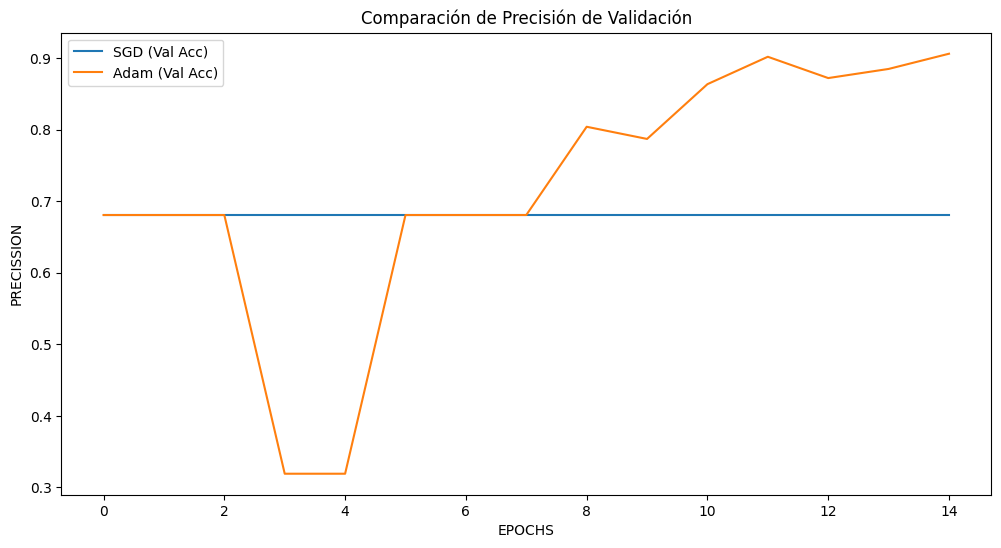

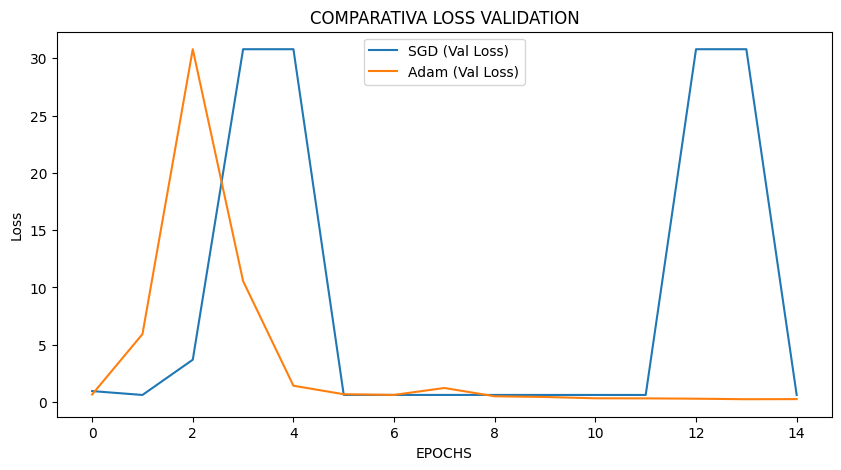

In [158]:
plt.figure(figsize=(12, 6))
for opt_name in optimizers:
    plt.plot(results[opt_name]['val_accs'], label=f'{opt_name} (Val Acc)')
plt.title('Comparación de Precisión de Validación')
plt.xlabel('EPOCHS')
plt.ylabel('PRECISSION')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for opt_name in optimizers:
    plt.plot(results[opt_name]['val_losses'], label=f'{opt_name} (Val Loss)')
plt.title('COMPARATIVA LOSS VALIDATION')
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.legend()
plt.show()

AJUSTE DE BATH SIZE Y EPOCHS

Entrenamos un modelo con diferentes tamaños de batch para optimizar su rendimiento. Toma como parámetros el tamaño del batch, el modelo, los datos de entrenamiento, los datos de validación, el dispositivo de ejecución y el número de epochs.

Se imprime el tamaño del batch utilizado.

Creamos DataLoaders para cargar los datos de entrenamiento y validación según el tamaño del batch.

Configuración:

Se define la función de pérdida (BCELoss), el optimizador (Adam) y el scheduler de aprendizaje (StepLR).

Entrenamiento:

Recorre cada epoch, entrenando el modelo y evaluándolo en los datos de validación.

Ajusta la tasa de aprendizaje con el scheduler.

Guarda y muestra las métricas de pérdida y precisión.

Resultado:

Devuelve las métricas de pérdidas y precisiones de entrenamiento y validación.

In [161]:
def train_with_batch_size(batch_size, model, train_data, val_data, device, num_epochs=10):
    """
    Entrena el modelo con un tamaño de batch específico.
    """
    print(f"\n[INFO]: Entrenando con batch_size = {batch_size}...\n")

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        scheduler.step()

        print(f'[INFO]: Época {epoch+1} ---> '
              f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
              f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')

    return train_losses, val_losses, train_accs, val_accs


In [162]:
# Tamaños de batch a probar
batch_sizes = [10, 20, 30]

# Resultados para cada batch size
batch_results = {}

for batch_size in batch_sizes:
    # Re-inicializar el modelo para cada experimento
    model = HybridModel(metadata_input_dim=10)
    model = model.to(device)

    # Entrenar con el batch size actual
    train_losses, val_losses, train_accs, val_accs = train_with_batch_size(
        batch_size, model, train_dataset, val_dataset, device, num_epochs=15
    )

    # Guardar resultados
    batch_results[batch_size] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[INFO]: Entrenando con batch_size = 10...

[INFO]: Época 1 ---> Loss_train = 0.8239, Acc_train = 0.6566, Loss_val = 0.6283, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6410, Acc_train = 0.6803, Loss_val = 0.7161, Acc_val = 0.4340, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6278, Acc_train = 0.6803, Loss_val = 1.5436, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6321, Acc_train = 0.6785, Loss_val = 0.6281, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6291, Acc_train = 0.6803, Loss_val = 1.5743, Acc_val = 0.3191, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6277, Acc_train = 0.6803, Loss_val = 0.6276, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.6272, Acc_train = 0.6803, Loss_val = 0.6275, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.6271, Acc_train = 0.6803, Loss_val = 0.6274, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.6269, Acc_train 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Época 1 ---> Loss_train = 0.7129, Acc_train = 0.6330, Loss_val = 31.6667, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6487, Acc_train = 0.6803, Loss_val = 4.5087, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6357, Acc_train = 0.6803, Loss_val = 0.6369, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6337, Acc_train = 0.6794, Loss_val = 0.6252, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6322, Acc_train = 0.6803, Loss_val = 0.6241, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6281, Acc_train = 0.6803, Loss_val = 0.6773, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.6286, Acc_train = 0.6803, Loss_val = 68.3333, Acc_val = 0.3191, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.6291, Acc_train = 0.6803, Loss_val = 3.1591, Acc_val = 0.3191, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.6289, Acc_train = 0.6803, Loss_val = 0.6846, Acc_val = 0.6

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Época 1 ---> Loss_train = 0.8624, Acc_train = 0.6412, Loss_val = 0.7220, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6736, Acc_train = 0.6721, Loss_val = 0.6261, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6592, Acc_train = 0.6785, Loss_val = 0.6250, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6341, Acc_train = 0.6803, Loss_val = 0.6297, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6393, Acc_train = 0.6803, Loss_val = 0.6408, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6338, Acc_train = 0.6803, Loss_val = 0.6330, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.6271, Acc_train = 0.6803, Loss_val = 0.6244, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.6280, Acc_train = 0.6803, Loss_val = 0.6269, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.6266, Acc_train = 0.6803, Loss_val = 0.6527, Acc_val = 0.680

Visualizamos resultados en los siguientes diagramas:

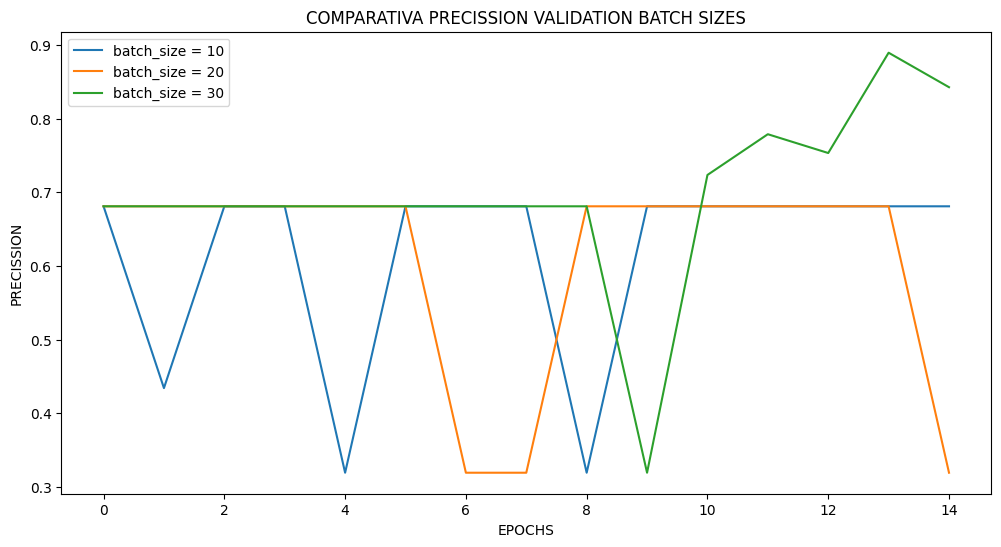

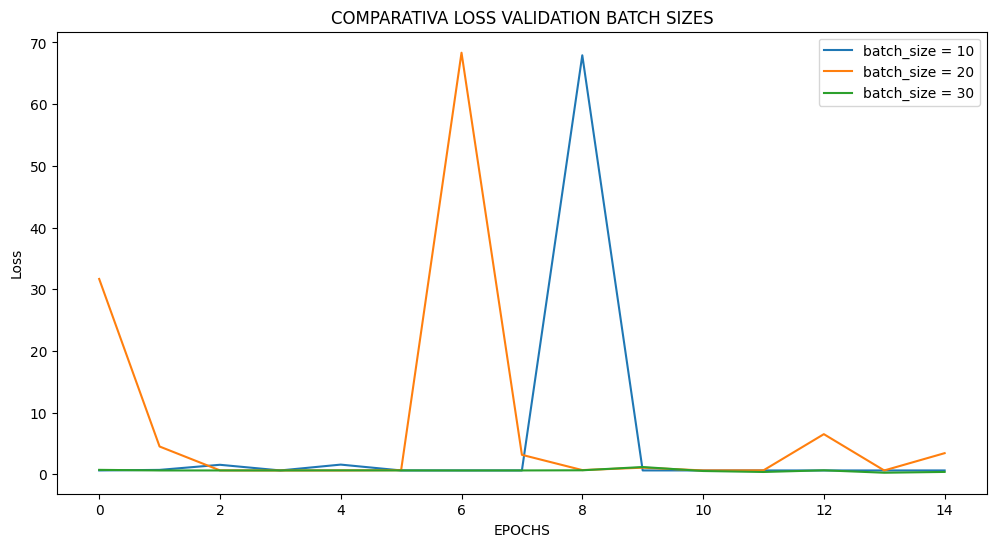

In [163]:
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    plt.plot(batch_results[batch_size]['val_accs'], label=f'batch_size = {batch_size}')
plt.title('COMPARATIVA PRECISSION VALIDATION BATCH SIZES')
plt.xlabel('EPOCHS')
plt.ylabel('PRECISSION')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    plt.plot(batch_results[batch_size]['val_losses'], label=f'batch_size = {batch_size}')
plt.title('COMPARATIVA LOSS VALIDATION BATCH SIZES')
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.legend()
plt.show()



ENTRENAMIENTO FINAL

Realizamos una última prueba

In [164]:
optimal_batch_size = 32  # Tamaño de lote óptimo
optimal_epochs = 20       # Número de épocas óptimo

model = HybridModel(metadata_input_dim=10)
model = model.to(device)

train_loader = DataLoader(train_dataset, batch_size=optimal_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=optimal_batch_size, shuffle=False)

optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.BCELoss()

train_losses, val_losses, train_accs, val_accs = [], [], [], []

print(f"Entrenamiento Final con batch_size = {optimal_batch_size} y epochs = {optimal_epochs}\n")

for epoch in range(optimal_epochs):

    train_loss, train_acc = train_epoch(model, device, train_loader, criterion, optimizer)

    val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    scheduler.step()

    print(f'[INFO]: Época {epoch+1} ---> '
          f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
          f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Entrenamiento Final con batch_size = 32 y epochs = 20

[INFO]: Época 1 ---> Loss_train = 0.7701, Acc_train = 0.6047, Loss_val = 0.6898, Acc_val = 0.5489, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6570, Acc_train = 0.6767, Loss_val = 0.6401, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6383, Acc_train = 0.6803, Loss_val = 0.6181, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6357, Acc_train = 0.6803, Loss_val = 0.6148, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6325, Acc_train = 0.6803, Loss_val = 0.6080, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6238, Acc_train = 0.6803, Loss_val = 0.5885, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.5527, Acc_train = 0.7432, Loss_val = 0.4736, Acc_val = 0.7787, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.4352, Acc_train = 0.8270, Loss_val = 0.3507, Acc_val = 0.8638, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.4382,

Revisamos los resultados del último entrenamiento

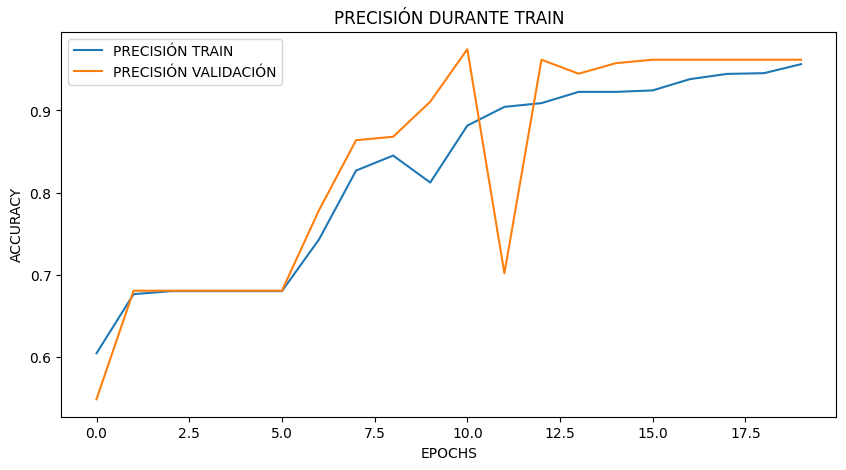

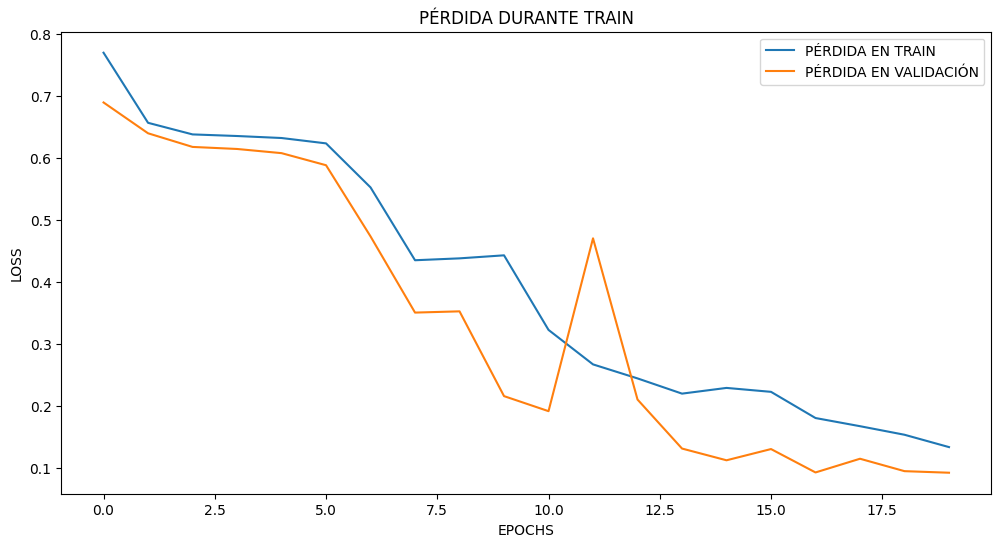

In [165]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='PRECISIÓN TRAIN')
plt.plot(val_accs, label='PRECISIÓN VALIDACIÓN')
plt.title('PRECISIÓN DURANTE TRAIN')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='PÉRDIDA EN TRAIN')
plt.plot(val_losses, label='PÉRDIDA EN VALIDACIÓN')
plt.title('PÉRDIDA DURANTE TRAIN')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()



GUARDAR EL MODELO

In [166]:

model_path = "/content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/hybrid_model.pth"

torch.save(hybrid_model.state_dict(), model_path)
print(f"Modelo guardado en {model_path}")

loaded_model = HybridModel(metadata_input_dim=10)
loaded_model = loaded_model.to(device)

loaded_model.load_state_dict(torch.load(model_path))
print("Modelo cargado correctamente")

loaded_model.eval()

Modelo guardado en /content/drive/MyDrive/KeepCoding/6.DeepLearning/Practica/hybrid_model.pth
Modelo cargado correctamente


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-166-f1683514c78f>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models 

HybridModel(
  (image_encoder): EfficientNetEncoder(
    (efficientnet): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), s